In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

import sys; sys.path.append('../../')

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series
from models.ihme.dataloader import get_dataframes_cached

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, train_val_split, calculate_loss
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, plot_forecast, get_forecast

## Comparison of E/Hosp and I/Hosp ratios

In [3]:
# for district in predictions_dict.keys():
#     district_dict = predictions_dict[district]
    
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-', color='C0', label='E / Hosp (M1)')
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-.', color='C0', label='I / Hosp (M1)')
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#     ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.ylabel('No of People')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
#     plt.grid()
#     plt.show()

## Load Covid19india Data

In [4]:
# dataframes = get_covid19india_api_data()
dataframes = get_dataframes_cached()

../../cache/dataframes_ts_03062020.pkl


In [5]:
predictions_dict = {}

## Select Districts to fit on

In [6]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

#districts_to_show = [('Maharashtra', 'Pune')]
districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

In [7]:
# for state, district in districts_to_show:
#    predictions_dict[(state, district)] = {}
#    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=7, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
#    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=0, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

Performing m1 fit ..
splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  recovered  \
35  maharashtra   mumbai 2020-05-18         21202.6       14853.8     5583.2   
36  maharashtra   mumbai 2020-05-19         22586.8       15811.8     5972.2   
37  maharashtra   mumbai 2020-05-20         24007.0       16783.4     6385.8   
38  maharashtra   mumbai 2020-05-21         25503.4       17849.4     6777.8   
39  maharashtra   mumbai 2020-05-22         27062.6       18979.4     7169.4   

    deceased  
35     765.6  
36     802.8  
37     837.8  
38     876.2  
39     913.8  
val
          state district       date  total_infected  hospitalised  recovered  \
0  maharashtra   mumbai 2020-05-23         28633.4       20125.6     7557.0   
1  maharashtra   mumbai 2020-05-24         30128.2       21171.2     7969.6   
2  maharashtra   mumbai 2020-05-25         31481.6       22092.2     8364.4   
3  maharashtra   mumbai 2020-05-26         3

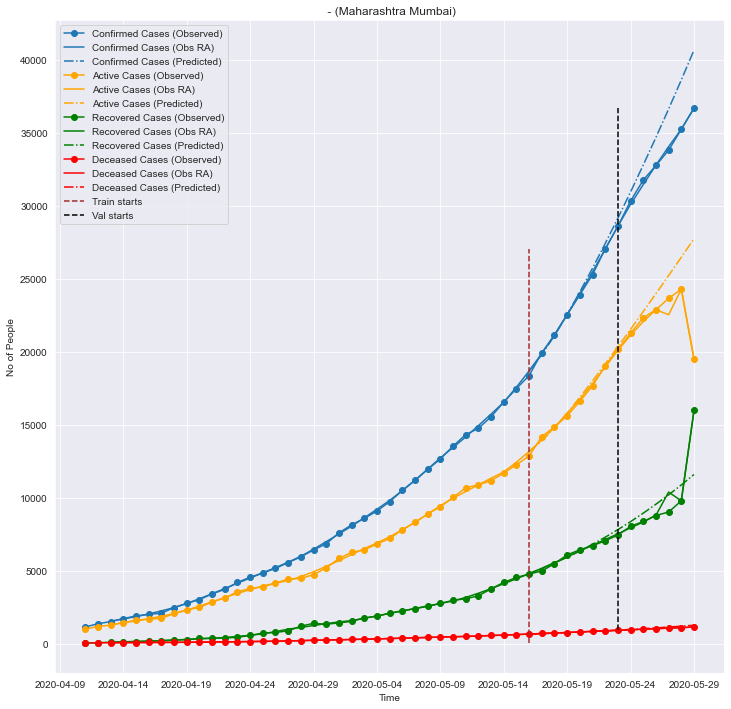

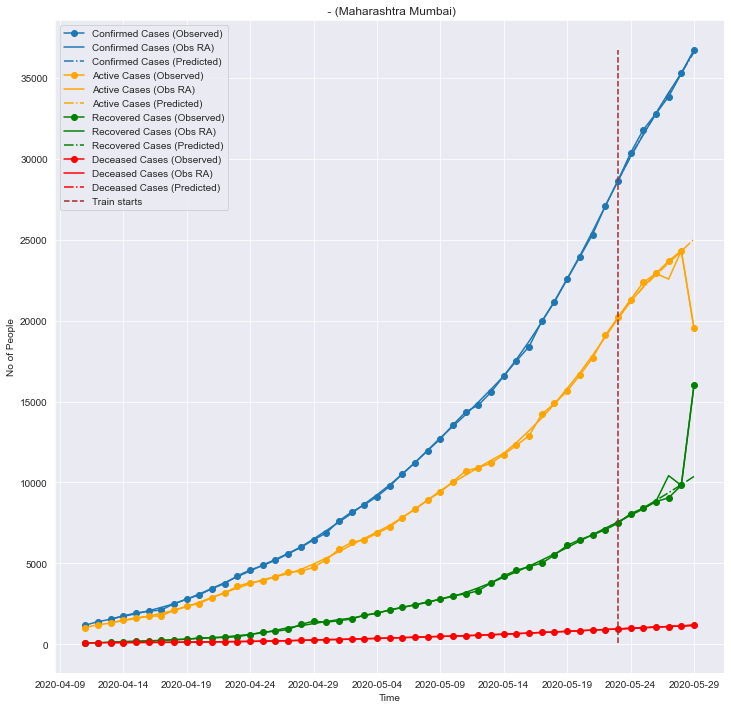

In [8]:
sns.set_style("dark")
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, 
        data_from_tracker=False,
        # filename='../../data/data/official-pune-21-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
    )
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, 
        data_from_tracker=False, 
        # filename='../../data/data/official-pune-25-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
    )

## Create Master Loss Dataframe

### M1 Loss

In [9]:
predictions_dict.keys()

dict_keys([('Maharashtra', 'Mumbai')])

In [22]:
predictions_dict[('Maharashtra','Mumbai')]['m1'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date'])

In [11]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in districts_to_show:
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         1.48           0.93     0.83      1.87   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai         7.52           5.54     5.21     11.75

### M2 Loss

In [35]:
#predictions_dict[('Maharashtra','Pune')]['m2']
predictions_dict[('Maharashtra','Mumbai')]['m2'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date'])

In [36]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         3.63           0.38     0.38      8.79

## Plot Forecasts

getting forecasts ..


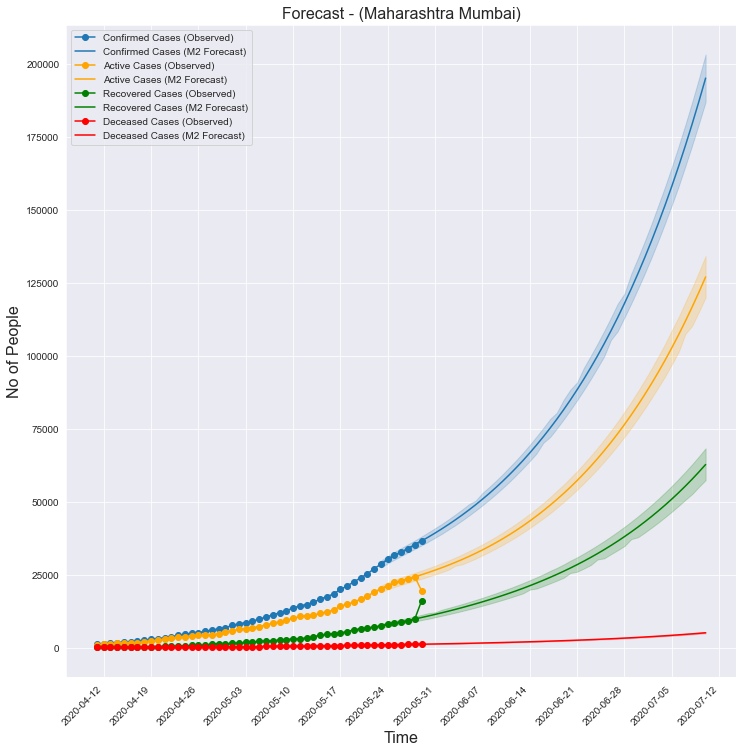

In [14]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create and Save Output CSV

In [37]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [38]:
write_csv(df_output, '../../output-mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [39]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m1']['trials']])
#losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
least_losses_indices = np.argsort(losses_array)
losses_array[least_losses_indices][:10]

array([2.29866831, 2.35884711, 2.471966  , 2.52809722, 2.56683512,
       2.58194372, 2.60372468, 2.64323338, 2.65226193, 2.73452175])

In [40]:
params_array = []
for trial in predictions_dict[(state, district)]['m1']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [41]:
least_losses_indices[:10]

array([1460,  581, 1050, 1346, 1245,  821, 1330,  587, 1429,  613])

In [20]:
params_array[least_losses_indices[:10]]

array([{'E_hosp_ratio': 0.7074314329830351, 'I_hosp_ratio': 0.27671988464631747, 'P_fatal': 0.07570235738489525, 'T_inc': 4.369719107640968, 'T_inf': 3.7563564521660484, 'T_recov_severe': 35.37674764863184, 'lockdown_R0': 1.2170885994077163},
       {'E_hosp_ratio': 0.6353772879366322, 'I_hosp_ratio': 0.33211573176382325, 'P_fatal': 0.07620061435095361, 'T_inc': 4.99489553363822, 'T_inf': 3.873453813913447, 'T_recov_severe': 33.246297260806884, 'lockdown_R0': 1.3284924880851074},
       {'E_hosp_ratio': 0.7708572299966211, 'I_hosp_ratio': 0.2939233139371997, 'P_fatal': 0.07890794726815, 'T_inc': 4.74328740411923, 'T_inf': 3.9017010924826288, 'T_recov_severe': 34.966196248677726, 'lockdown_R0': 1.2164853330322734},
       {'E_hosp_ratio': 0.6930812016106984, 'I_hosp_ratio': 0.19516751545193595, 'P_fatal': 0.07987488496204863, 'T_inc': 4.44004977537613, 'T_inf': 3.071116535169152, 'T_recov_severe': 34.2616493551498, 'lockdown_R0': 1.3032649195784864},
       {'E_hosp_ratio': 0.5780100815

In [42]:
#predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Pune')],
#                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]
predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


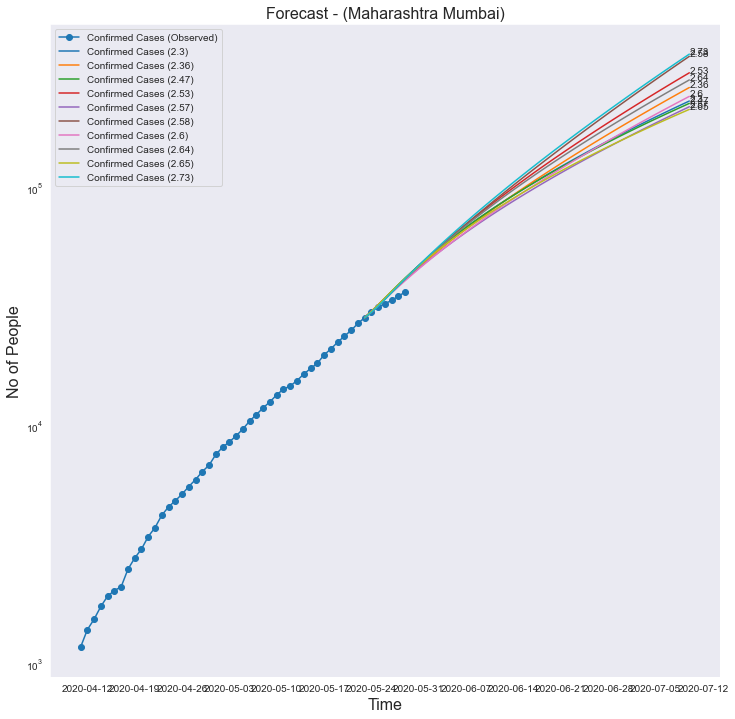

In [23]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']

#sns.set_style("ticks")
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['total_infected'],
        '-o', color='C0', label='Confirmed Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    sns.lineplot(x="date", y="total_infected", data=df_prediction,
                 ls='-', label='Confirmed Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

In [43]:
df_true

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,mumbai,2020-04-11,1182,1036,71,75
1,maharashtra,mumbai,2020-04-12,1399,1211,97,91
2,maharashtra,mumbai,2020-04-13,1549,1308,141,100
3,maharashtra,mumbai,2020-04-14,1753,1478,164,111
4,maharashtra,mumbai,2020-04-15,1936,1642,181,113
5,maharashtra,mumbai,2020-04-16,2043,1725,202,116
6,maharashtra,mumbai,2020-04-17,2120,1760,239,121
7,maharashtra,mumbai,2020-04-18,2509,2103,281,125
8,maharashtra,mumbai,2020-04-19,2798,2357,310,131
9,maharashtra,mumbai,2020-04-20,3050,2518,394,138


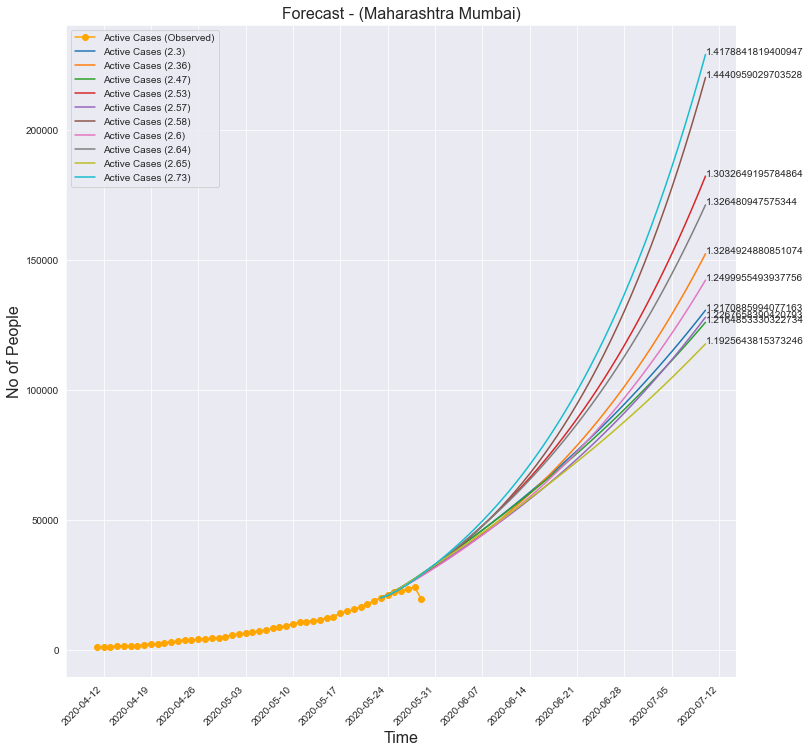

In [44]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = params_dict[i]['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
    #if true_r0 > 1.7:
    #    continue
    #if true_r0 == 0.59 or true_r0 == 1.04:
    #    continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

## Check varying R0 values

In [45]:
params_to_plot = \
{
    'low':{'E_hosp_ratio': 0.115406221316017, 'I_hosp_ratio': 0.4763871081949848, 'P_fatal': 0.050419345187462467, 'P_severe': 0.7809853621826006, 'T_inc': 4.484977212179257, 'T_inf': 3.3342249004558697, 'T_recov_severe': 52.054485355979445, 'lockdown_R0': 1.0974118812671074},
    'medium':{'E_hosp_ratio': 0.5105188613649609, 'I_hosp_ratio': 0.3039459885534656, 'P_fatal': 0.05832975188719784, 'P_severe': 0.8668707539589996, 'T_inc': 4.554494614633725, 'T_inf': 3.3958101193846915, 'T_recov_severe': 48.49542471232895, 'lockdown_R0': 1.1227557408135034},
    'high':   {'E_hosp_ratio': 0.2806960144261442, 'I_hosp_ratio': 0.3800638057872212, 'P_fatal': 0.05326820833691313, 'P_severe': 0.8339542948758695, 'T_inc': 4.304052648857938, 'T_inf': 3.4673218430188513, 'T_recov_severe': 47.044942872805294, 'lockdown_R0': 1.3444274930627533}
}
multipliers = [0.9, 1, 1.1, 1.25]
columns_for_csv = ['date', 'total_infected', 'hospitalised', 'recovered', 'deceased']


In [46]:
def set_r0_multiplier(params_dict, mul):
    new_params = params_dict.copy()
    new_params['post_lockdown_R0']= params_dict['lockdown_R0']*mul
    return new_params


predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=set_r0_multiplier(best_params_dict, mul)) \
                                 for mul in multipliers]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [54]:
df_district = predictions_dict[districts_to_show[0]]['m2']['df_district']
df_train_nora, df_val_nora, df_true_fitting = train_val_split(
                df_district, train_rollingmean=False, val_rollingmean=False, val_size=0)

for key in params_to_plot:
    print("R0", params_to_plot[key]['lockdown_R0'])
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params = best_params_dict)
    df_loss = calculate_loss(df_train_nora, df_val_nora, df_predictions, train_period=7,
                             which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss)
    #print(df_loss.sum())

splitting data ..
R0 1.0974118812671074
getting forecasts ..
                   train
hospitalised     11.1752
total_infected   5.97783
deceased        0.399696
recovered        8.74662
R0 1.1227557408135034
getting forecasts ..
                  train
hospitalised     9.3144
total_infected  4.78276
deceased        1.14511
recovered       8.62226
R0 1.3444274930627533
getting forecasts ..
                   train
hospitalised     9.58182
total_infected   5.07594
deceased        0.561983
recovered        8.73014


getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-low-0.9.csv
Mumbai-low-1.csv
Mumbai-low-1.1.csv
Mumbai-low-1.25.csv


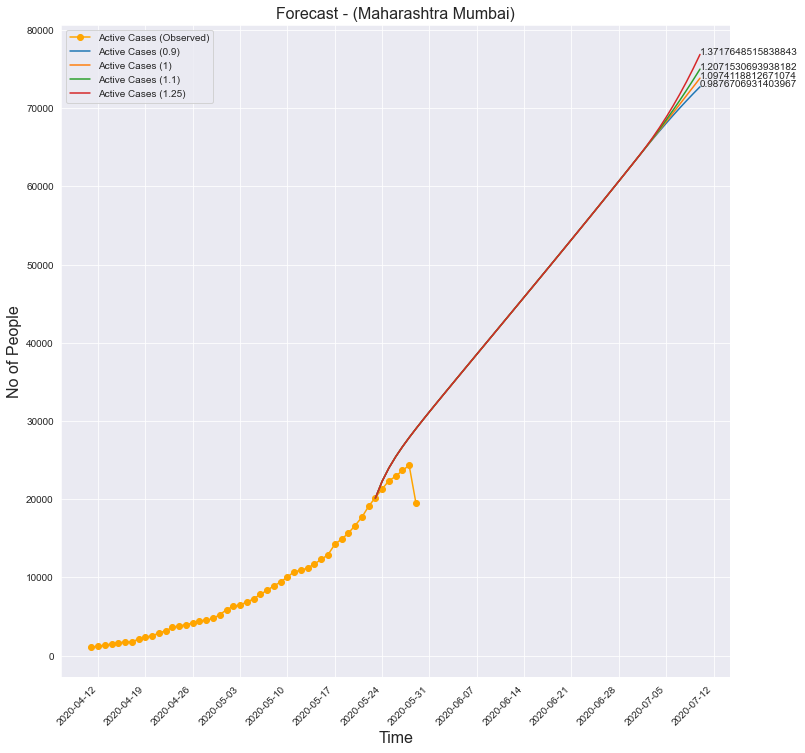

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-medium-0.9.csv
Mumbai-medium-1.csv
Mumbai-medium-1.1.csv
Mumbai-medium-1.25.csv


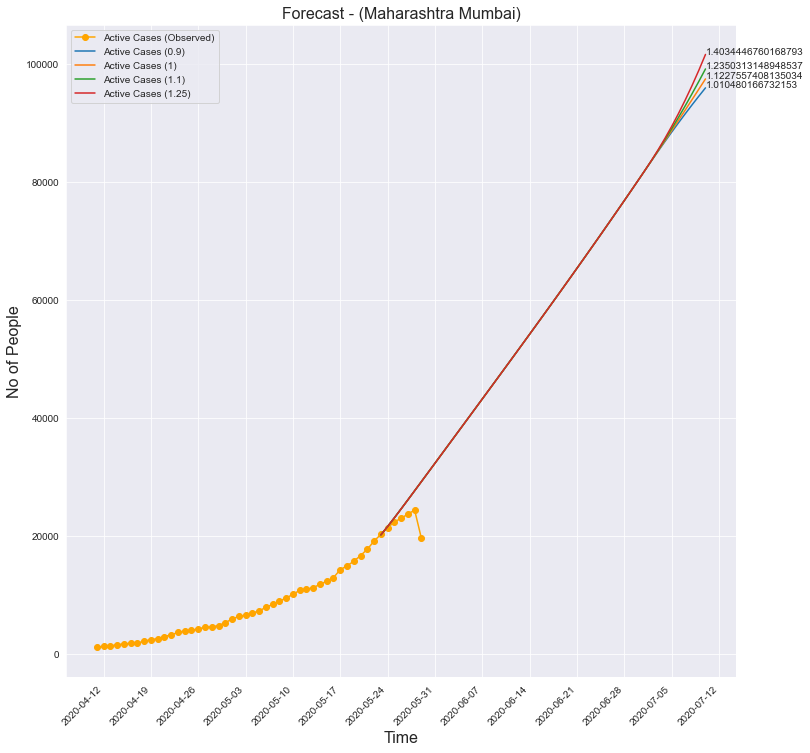

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-high-0.9.csv
Mumbai-high-1.csv
Mumbai-high-1.1.csv
Mumbai-high-1.25.csv


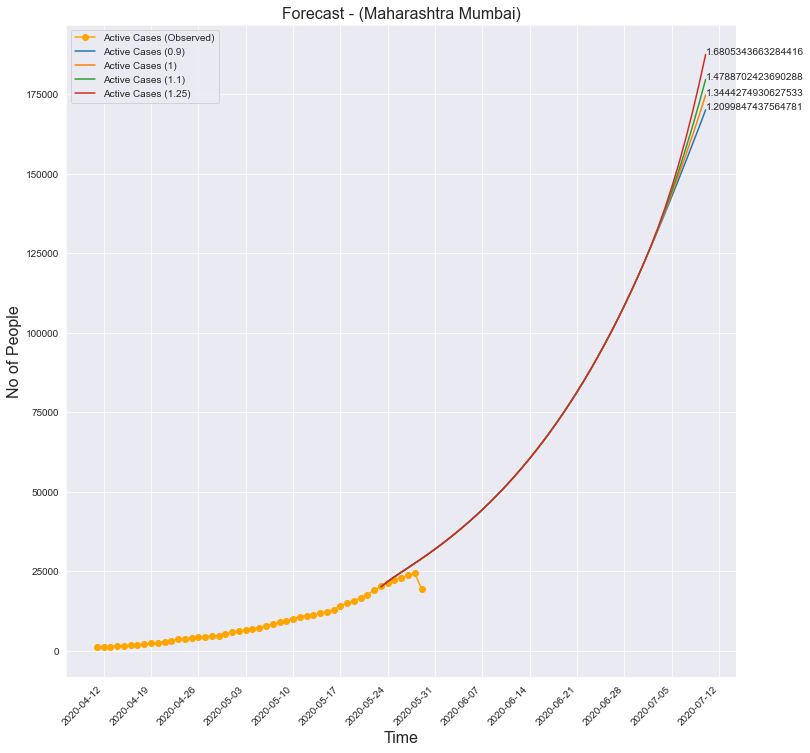

In [69]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
params_array[least_losses_indices[:10]]
for key in params_to_plot:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params=set_r0_multiplier(best_params_dict, mul))
                                 for mul in multipliers]
    for i, df_prediction in enumerate(predictions_array_mul):
        filename = "Mumbai-" + key + "-" + str(multipliers[i]) + ".csv"
        print(filename)
        today = datetime.date.today().strftime("%Y-%m-%d")
        path = f'../../outputs/Mumbai-{today}/'
        if not os.path.exists(path):
            os.mkdir(path)
        df_prediction[columns_for_csv].to_csv(os.path.join(path, filename))
        #loss_value = np.around(np.sort(losses_array)[:10][i], 2)
        label = multipliers[i]
        true_r0 = label*best_params_dict['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
        #if true_r0 > 1.7:
        #    continue
        #if true_r0 == 0.59 or true_r0 == 1.04:
        #    continue
        sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                     ls='-', label='Active Cases ({})'.format(label))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    # plt.yscale('log')
    plt.xticks(rotation=45,horizontalalignment='right')

    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    plt.show()     

In [70]:

for elt in params_array[least_losses_indices[:10]]:
    print("R0", elt['lockdown_R0'])
    #best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(
        predictions_dict[('Maharashtra', 'Mumbai')],
        train_fit = "m1",
        best_params = elt)
    df_loss = calculate_loss(
        df_train_nora, df_val_nora, df_predictions, train_period=7,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss.iloc[1])


R0 1.2170885994077163
getting forecasts ..
train    5.54272
Name: total_infected, dtype: object
R0 1.3284924880851074
getting forecasts ..
train    4.03223
Name: total_infected, dtype: object
R0 1.2164853330322734
getting forecasts ..
train    5.77931
Name: total_infected, dtype: object
R0 1.3032649195784864
getting forecasts ..
train    6.33231
Name: total_infected, dtype: object
R0 1.2267658390420793
getting forecasts ..
train    2.65145
Name: total_infected, dtype: object
R0 1.4440959029703528
getting forecasts ..
train    6.05067
Name: total_infected, dtype: object
R0 1.2499955493937756
getting forecasts ..
train    2.79162
Name: total_infected, dtype: object
R0 1.326480947575344
getting forecasts ..
train    5.66181
Name: total_infected, dtype: object
R0 1.1925643815373246
getting forecasts ..
train    4.87217
Name: total_infected, dtype: object
R0 1.4178841819400947
getting forecasts ..
train    7.0772
Name: total_infected, dtype: object


In [75]:
columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered',
           'current_deceased', 'current_hospitalized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min',
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean',
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

region = ('Maharashtra', 'Mumbai')

df_final = pd.DataFrame(columns=columns)
for params_dict in params_array[least_losses_indices[:10]]:
    df_output = create_region_csv(predictions_dict[region], region=region[1],
    regionType='district', best_params=params_dict,
    icu_fraction=0.02)
    df_final = pd.concat([df_final, df_output], ignore_index=True)
    

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [76]:
df_final.to_csv('../../outputs/mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [77]:
df_final

,forecastRunDate,regionType,region,model_name,error_function,error_value,current_total,current_active,current_recovered,current_deceased,...,icu_max,deceased_mean,deceased_min,deceased_max,recovered_mean,recovered_min,recovered_max,total_mean,total_min,total_max
0,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,1182,NaN,71,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,1399,NaN,97,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,1549,NaN,141,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,1753,NaN,164,111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,1936,NaN,181,113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,NaN,NaN,NaN,NaN,...,4167.71,10111,9583.74,10638.3,102897,90807.8,114986,306811,289805,323817
906,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,NaN,NaN,NaN,NaN,...,4347.85,10607,10053.9,11160.1,108082,95383.6,120780,320869,303084,338654
907,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,NaN,NaN,NaN,NaN,...,4534.67,11123,10543,11703,113492,100158,126826,335482,316887,354077
908,2020-06-03,district,Mumbai,SEIR,MAPE,5.542716,NaN,NaN,NaN,NaN,...,4728.38,11662,11053.9,12270.1,119133,105136,133130,350670,331233,370107


In [78]:
for index, params_dict in enumerate(params_array[least_losses_indices[:10]]):
    print('Loss - ', np.around(losses_array[least_losses_indices[:10][index]], 2))
    params_dict_temp = copy.copy(params_dict)
    params_dict_temp['true_R0'] = params_dict_temp['lockdown_R0']#*params_dict_temp['intervention_amount']
    #del params_dict_temp['intervention_amount']
    del params_dict_temp['lockdown_R0']
    for key in params_dict_temp.keys():
        params_dict_temp[key] = np.around(params_dict_temp[key], 2)
    print('Params - ', params_dict_temp)
    print('\n')

Loss -  2.3
Params -  {'E_hosp_ratio': 0.71, 'I_hosp_ratio': 0.28, 'P_fatal': 0.08, 'T_inc': 4.37, 'T_inf': 3.76, 'T_recov_severe': 35.38, 'true_R0': 1.22}


Loss -  2.36
Params -  {'E_hosp_ratio': 0.64, 'I_hosp_ratio': 0.33, 'P_fatal': 0.08, 'T_inc': 4.99, 'T_inf': 3.87, 'T_recov_severe': 33.25, 'true_R0': 1.33}


Loss -  2.47
Params -  {'E_hosp_ratio': 0.77, 'I_hosp_ratio': 0.29, 'P_fatal': 0.08, 'T_inc': 4.74, 'T_inf': 3.9, 'T_recov_severe': 34.97, 'true_R0': 1.22}


Loss -  2.53
Params -  {'E_hosp_ratio': 0.69, 'I_hosp_ratio': 0.2, 'P_fatal': 0.08, 'T_inc': 4.44, 'T_inf': 3.07, 'T_recov_severe': 34.26, 'true_R0': 1.3}


Loss -  2.57
Params -  {'E_hosp_ratio': 0.58, 'I_hosp_ratio': 0.27, 'P_fatal': 0.08, 'T_inc': 4.77, 'T_inf': 3.18, 'T_recov_severe': 38.55, 'true_R0': 1.23}


Loss -  2.58
Params -  {'E_hosp_ratio': 0.67, 'I_hosp_ratio': 0.31, 'P_fatal': 0.08, 'T_inc': 4.92, 'T_inf': 3.88, 'T_recov_severe': 33.17, 'true_R0': 1.44}


Loss -  2.6
Params -  {'E_hosp_ratio': 0.55, 'I_ho